In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches

import math
import scipy

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

# Ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


## Load Data

In [2]:
IDS_MAPPING_FN = "./data/IDS_mapping.csv"
DIABETIC_FN = "./data/diabetic_data.csv"
FIGURES_PATH = "./figures/"

In [3]:
# read files
mapping = pd.read_csv(IDS_MAPPING_FN, header=None)
df = pd.read_csv(DIABETIC_FN)

In [4]:
MEDIC_COLUMNS = df.columns[24:46].tolist()
MEDIC_COLUMNS_TAKE = ["take_" + med for med in MEDIC_COLUMNS]
PREVIOUS_HOSPITAL_ENCOUNTERS = ["number_outpatient", "number_inpatient", "number_emergency"]

Create dictionary of code-value mappings of `admission_type_id`, `discharge_disposition_id`, and `admission_source_id` using the mapping provided in the data-folder, and map integer values to string values for readability. 

In [5]:
admission_type_dict = {}
discharge_disposition_dict = {}
admission_source_dict = {}

list1 = []
for i, j in zip(mapping[0].values, mapping[1].values):
  if len(str(i))>3:
    feature_name = i
  elif len(str(i))!=3:
    if feature_name == 'admission_type_id':
      admission_type_dict[int(i)] = j
    elif feature_name == 'discharge_disposition_id':
      discharge_disposition_dict[int(i)] = j
    elif feature_name == 'admission_source_id':
      admission_source_dict[int(i)] = j


df['admission_type'] = df['admission_type_id'].apply(lambda x: admission_type_dict[x])
df['discharge_disposition'] = df['discharge_disposition_id'].apply(lambda x: discharge_disposition_dict[x])
df['admission_source'] = df['admission_source_id'].apply(lambda x: admission_source_dict[x])

In [6]:
print(f"Number of unique encounters: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of unique encounters: 101766
Number of columns: 53


## Preprocessing

Some patients have many encounters (up to 40).

We only keep the first observation for each unique patient to treat them as i.i.d random variables.

We filter to only keep observations with `admission_type` $\in$ [Emergency, Urgent, Elective].

In [7]:
df = df.groupby("patient_nbr").first(skipna=False).reset_index()
df = df[df['admission_type'].isin(['Emergency', 'Urgent', 'Elective'])]
df = df[df['race'].isin(['Caucasian', 'AfricanAmerican', 'Hispanic', 'Asian'])]
print(f"Number of unique encounters after only keeping first encounter for each patient and filtering by admission_type : {df.shape[0]}")

Number of unique encounters after only keeping first encounter for each patient and filtering by admission_type : 60571


#### Feature Engineering: Diabetic Information

To select features as predictor variables we are only interested in certain information about the patients, but not the exact values. Thus we aggregate the information of sets of columns into new columns:


* Blood Glucose Tests

    * `max_glu_serum_flag`: Whether a max glucose serum test was done at the hospital : `max_glu_serum`


    * `A1C_flag`: Whether an AC1 test was performed to monitor blood glucose levels : `AC1result`

    
* Diabetic Medication Information: 

    * `change_dosage`: Whether there was any change ("Up" or "Down") in the diabetic prescription dosages as a result of the hospital visit.
        * *The column `change` indicates if there was a change in diabetic medications (either dosage or generic name). So if `change` is marked as changed but `change_dosage` is none, then there must have been a change in the generic name, i.e. the chemical name of a medicine.*


    * `change_medicine`: Whether there was prescribed any new diabetic medication i.e. a change in the medicament as a result of the hospital visit.


    * `num_diabetic_prescriptions`: How many diabetic prescriptions the patient ongoingly had at the time of hospital visit - a count of entries that are $\in \{\text{"Steady"}, \text{"Up"}, \text{"Down"}\}$ in `MEDIC_COLUMNS`

    * `take_<medicine_name>`: Whether the patient takes the <medicine_name> 


* Admitted in the hospital within the previous year

    * `prev_year_hospital`: Whether the patient had any admissions in the hospital during the past year. 

* Health Insurance / Coverage

    * `blue_cross`: Patient has private insurance
    * `medicaid`: Patient has medicaid
    * `medicare`: Patient has medicare
    * `self_payed`: Patient payed up front
  
* `discharge_disposition_id`: is aggregated into `home`, `transfer`, `unknown`, and `other`

* `Age` is aggregated into `[0-30)`, `[30-60)`, and `[60-100)`

* Readmitted
    * `readmitted_flag`: Whether the patient was readmitted or not based on the columns `readmitted`


In [8]:
#### Blood glucose Tests ####
df['max_glu_serum_flag'] = df['max_glu_serum'].notnull().astype(int) # Max Glucose Serum test flag
df['A1C_flag'] = df['A1Cresult'].notnull().astype(int) # AC1 test flag

#### Diabetic Medication Information ####
# Change in dosage if any of the diabetics prescriptions has entries "Up" or "Down"
df['change_dosage'] = df[MEDIC_COLUMNS].isin(['Up', 'Down']).any(axis=1).astype(int)
# Check if each entry is in the set ['Up', 'Down', 'Steady'] and sum all True entries for each row
df['num_diabetic_prescriptions'] = df[MEDIC_COLUMNS].apply(lambda col: np.isin(col, ['Up', 'Down', 'Steady'])).sum(axis=1).astype(int)
# Change in medicine is assumed to be the case when original change column = 1 but change in dosage = 0
df['change_medicine'] = np.where((df['change'] == 'Ch') & (df['change_dosage'] == 0), 1, 0)

# Whether the patient takes any of the medications
for med in MEDIC_COLUMNS:
    if len(np.unique(df[med])) == 1:
        MEDIC_COLUMNS_TAKE.remove("take_" + med) # some medications were taken by no patients
        continue
    name = "take_" + med
    df[name] = df[med].isin(["Down", "Steady", "Up"])


#### Hospital Encounters during preceding year ####
df['prev_year_hospital'] = (df[PREVIOUS_HOSPITAL_ENCOUNTERS] > 0).any(axis=1).astype(int)

#### Insurance Billing ####
df['blue_cross'] = np.where(df["payer_code"]=="BC", 1, 0)
df['medicare'] = np.where(df["payer_code"]=="MC", 1, 0)
df['medicaid'] = np.where(df["payer_code"]=="MD", 1, 0)
df['self_pay'] = np.where(df["payer_code"]=="SP", 1, 0)

#### Discharge disposition id aggregated ####
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace([1, 6, 8, 13], "home")
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace([2, 3, 4, 5, 9, 10, 14, 15, 16, 17, 22, 23, 24, 27, 28, 29], "transfer")
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace([18, 25, 26], "unknown")
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace([7, 11, 12, 19, 20, 21], "other")

#### Readmitted ####
# y_i
df['readmitted_flag'] = np.where(df['readmitted']=='NO', 0, 1) # Readmitted flag

#### Age aggregaed ####
df['age'] = df['age'].replace(['[0-10)', '[10-20)','[20-30)'], '[0-30)')
df['age'] = df['age'].replace(['[30-40)', '[40-50)','[50-60)'], '[30-60)')
df['age'] = df['age'].replace(['[60-70)', '[70-80)','[80-90)', '[90-100)'], '[60-100)')

## Define variables

In [9]:
FEATURES_NUM = ["time_in_hospital", "num_lab_procedures", "num_procedures", 'num_diabetic_prescriptions', 
                "num_medications", 'prev_year_hospital', "number_diagnoses"]

FEATURES_BIN = ['max_glu_serum_flag', 'A1C_flag', 'change_dosage', 'change_medicine', "blue_cross", "medicaid", "medicare","self_pay"]

FEATURES_CAT = ['discharge_disposition_id', "admission_type"]

FEATURES = FEATURES_NUM + FEATURES_BIN + FEATURES_CAT + MEDIC_COLUMNS_TAKE

PROTECTED_FEATURES = ['age','race', 'gender']
PATIENTS = ["patient_nbr"]  
TARGET = ["readmitted_flag"]

In [10]:
df = df[PATIENTS + FEATURES + PROTECTED_FEATURES + TARGET]

In [11]:
#One hot encode categorical features and protected features
df_one_hot = pd.get_dummies(df, prefix=None, prefix_sep='_', dummy_na=False, columns=FEATURES_CAT, drop_first=False)
df_one_hot = df_one_hot.drop(["discharge_disposition_id_unknown"], axis = 1)
FEATURES_ONE_HOT = df_one_hot.drop(PATIENTS+PROTECTED_FEATURES+TARGET, axis=1).columns.tolist()

df_one_hot = pd.get_dummies(df_one_hot, prefix=None, prefix_sep='_', dummy_na=False, columns=PROTECTED_FEATURES, drop_first=False)
PROTECTED_FEATURES_ONE_HOT = df_one_hot.drop(PATIENTS+FEATURES_ONE_HOT+TARGET, axis=1).columns.tolist()

Undersample majority class

In [12]:
df_major = df_one_hot[df_one_hot['readmitted_flag'] == 0]
df_minor = df_one_hot[df_one_hot['readmitted_flag'] == 1]

df_downsamples = resample(df_major, replace=False, n_samples=len(df_minor), random_state=42)  

df_one_hot = pd.concat([df_downsamples, df_minor])

Define train/test split

In [13]:
X = df_one_hot[FEATURES_ONE_HOT]
y = df_one_hot[TARGET].to_numpy().reshape(-1)
protected_features = df_one_hot[PROTECTED_FEATURES_ONE_HOT]

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(X, y, protected_features, test_size=0.2, random_state=42)

In [14]:
scaler = StandardScaler()
scaler.fit(X_train[FEATURES_NUM])
X_train[FEATURES_NUM] = scaler.transform(X_train[FEATURES_NUM])
X_test[FEATURES_NUM] = scaler.transform(X_test[FEATURES_NUM])

Using Grid search and Cross Validation we found an inverse regularisation strength of $0.1$  

In [15]:
def fit_logistic_regression(features_train, targets_train, features_test):
    logistic_model = LogisticRegression(max_iter=5000, penalty='l2', C=0.1, tol=1e-4, solver = "saga")
    logistic_model.fit(features_train, targets_train)
    y_pred = logistic_model.predict(features_test)
    y_proba = logistic_model.predict_proba(features_test)
    coefs = logistic_model.coef_
    return y_pred, y_proba, coefs

In [16]:
def get_metrics_overall(y_test_, y_pred_):
    accuracy = accuracy_score(y_test_, y_pred_)
    fpr, tpr, thresholds = roc_curve(y_test_, y_pred_)
    
    return accuracy, tpr[1], fpr[1]

In [17]:
def get_metrics_per_group(group_test_: pd.DataFrame, y_test_: np.array, y_pred_: np.array, protected_group: str, protected_feature_names=PROTECTED_FEATURES_ONE_HOT):
    '''
    Calculates accuracy, true positive rate, (tpr), and false positive rate (fpr) for the specified protected group. 
    '''
    group_names, accuracies, tprs, fprs = [], [], [], []
    protected_feature_names = [group for group in protected_feature_names if protected_group in group]
    df_ = pd.concat([group_test_, pd.DataFrame({'y_test': y_test_, 'y_pred': y_pred_}, index=group_test_.index)], axis=1)
    
    for group_col in protected_feature_names:
        group_df = df_[df_[group_col]==True]
        y_true = group_df['y_test']
        y_pred = group_df['y_pred']
        
        accuracy = accuracy_score(y_true, y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        
        group_names.append(group_col)
        accuracies.append(accuracy)
        tprs.append(tpr[1])
        fprs.append(fpr[1])
        
    return group_names, accuracies, tprs, fprs

## Decorrelate dataset

We define the function for decorrelating features using the method from the paper "A Geometric Solution to Fair Representations".

In [18]:
def correlation_remover(features, protected_features, lambda_):
    '''
    Decorrelate non-protected features with protected features.
    Lambda_ (fairness level) is in the interval [0,1], where 0; high fairness and 1; low fairness. 
    '''
    assert features.shape[0]==protected_features.shape[0]
    
    features_cols = features.columns
    
    #convert features to numeric matrices so we can do linalg operations
    features = features.astype(int).values
    protected_features = protected_features.astype(int).values
    
    # Find orthonormal basis of protected features
    orthobasis = scipy.linalg.orth(protected_features)
    
    # calculate projection of non-protected features onto orthonormal basis)
    features_decorrelated = features - orthobasis @ (orthobasis.T @ features)
    
    # Controlling the level of fairness. Subtract the projection from the original nonprotected features and scaling with fairness_level.
    features_decorrelated = features_decorrelated + lambda_ * (features - features_decorrelated)
    
    #convert to dataframe using the extracted column names
    features_decorrelated = pd.DataFrame(features_decorrelated, columns=features_cols)
    
    return features_decorrelated

We define 31 lambdas in linear space from [0,1]

In [19]:
num_lambda = 31
LAMBDAS = np.linspace(0,1,num_lambda)

Calculate accuracy, tpr, and fpr for each group across all lambdas.

In [20]:
overall_accuracies, tprs, fprs = [], [], []
gender_accuracies, gender_tprs, gender_fprs = [], [], []
race_accuracies, race_tprs, race_fprs = [], [], []
age_accuracies, age_tprs, age_fprs = [], [], []

#for lambda_ in np.logspace(-(num_lambda-1), 0, num_lambda):
for lambda_ in LAMBDAS:
    X_train_decorrelated = correlation_remover(X_train, group_train, lambda_)
    X_test_decorrelated = correlation_remover(X_test, group_test, lambda_)
    
    predictions, probas, _ = fit_logistic_regression(X_train_decorrelated, y_train, X_test_decorrelated)
    
    accuracy, tpr, fpr = get_metrics_overall(y_test, predictions)
    gender_name, gender_accuracy, gender_tpr, gender_fpr = get_metrics_per_group(group_test, y_test, predictions, 'gender')
    race_name, race_accuracy, race_tpr, race_fpr = get_metrics_per_group(group_test, y_test, predictions, 'race')
    age_name, age_accuracy, age_tpr, age_fpr = get_metrics_per_group(group_test, y_test, predictions, 'age')
        
    #Append to all lists
    overall_accuracies.append(accuracy)
    tprs.append(tpr)
    fprs.append(fpr)
    
    gender_accuracies.append(gender_accuracy)
    gender_tprs.append(gender_tpr)
    gender_fprs.append(gender_fpr)
    
    race_accuracies.append(race_accuracy)
    race_tprs.append(race_tpr)
    race_fprs.append(race_fpr)
    
    age_accuracies.append(age_accuracy)
    age_tprs.append(age_tpr)
    age_fprs.append(age_fpr)

## Protected Groups Figures Original Data

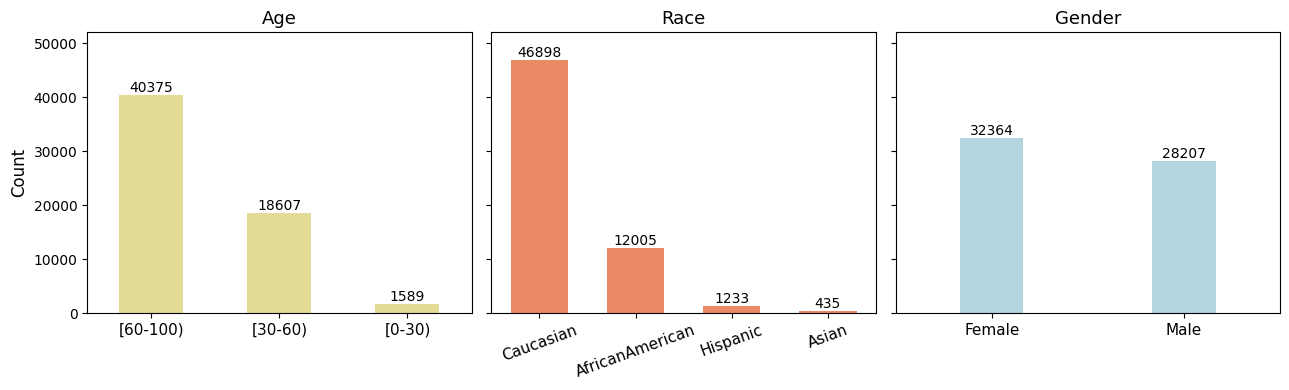

In [21]:
age_counts = df.groupby('age').size()
race_counts = df.groupby('race').size()
gender_counts = df.groupby('gender').size()
age_counts = age_counts.sort_values(ascending=False)
race_counts = race_counts.sort_values(ascending=False)
gender_counts = gender_counts.sort_values(ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)  

sns.barplot(x=age_counts.index, y=age_counts.values, ax=axes[0], color='khaki', width=0.5)
axes[0].set_title('Age', fontsize=13)
axes[0].set_xlabel('')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].bar_label(axes[0].containers[0]) 
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0, ha='center', fontsize=11)
axes[0].set_ylim(0,52000)

sns.barplot(x=race_counts.index, y=race_counts.values, ax=axes[1], color='coral', width=0.6)
axes[1].set_title('Race', fontsize=13)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].bar_label(axes[1].containers[0])  
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=20, ha='center', fontsize=11)
axes[1].set_ylim(0,52000)

sns.barplot(x=gender_counts.index, y=gender_counts.values, ax=axes[2], color='lightblue', width=0.33)
axes[2].set_title('Gender', fontsize=13)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].bar_label(axes[2].containers[0]) 
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0, ha='center', fontsize=11)
axes[2].set_ylim(0,52000)

plt.tight_layout()
plt.savefig(FIGURES_PATH+"count.svg") 
plt.show()

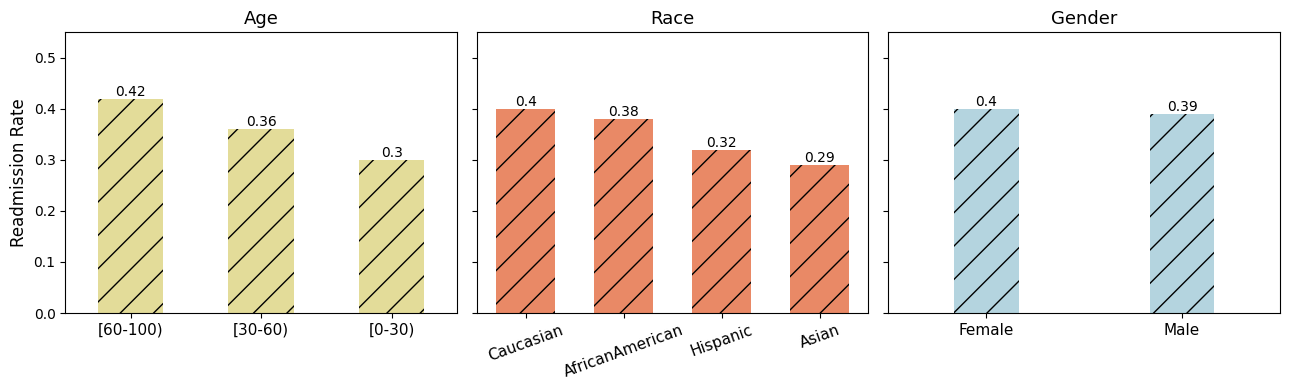

In [22]:
age_counts = df.groupby('age')['readmitted_flag'].mean()
race_counts = df.groupby('race')['readmitted_flag'].mean()
gender_counts = df.groupby('gender')['readmitted_flag'].mean()
age_counts = age_counts.sort_values(ascending=False)
race_counts = race_counts.sort_values(ascending=False)
gender_counts = gender_counts.sort_values(ascending=False)
age_counts = age_counts.round(2)
race_counts = race_counts.round(2)
gender_counts = gender_counts.round(2)

fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)  

sns.barplot(x=age_counts.index, y=age_counts.values, ax=axes[0], color='khaki', width=0.5, hatch='/')
axes[0].set_title('Age', fontsize=13)
axes[0].set_xlabel('')
axes[0].set_ylabel('Readmission Rate', fontsize=12)
axes[0].bar_label(axes[0].containers[0]) 
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0, ha='center', fontsize=11)
axes[0].set_ylim(0,0.55)

sns.barplot(x=race_counts.index, y=race_counts.values, ax=axes[1], color='coral', width=0.6, hatch='/')
axes[1].set_title('Race', fontsize=13)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].bar_label(axes[1].containers[0])  
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=20, ha='center', fontsize=11)
axes[1].set_ylim(0,0.55)

sns.barplot(x=gender_counts.index, y=gender_counts.values, ax=axes[2], color='lightblue', width=0.33, hatch='/')
axes[2].set_title('Gender', fontsize=13)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].bar_label(axes[2].containers[0]) 
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0, ha='center', fontsize=11)
axes[2].set_ylim(0,0.55)

plt.tight_layout()
plt.savefig(FIGURES_PATH+"demographic_parity.svg") 

## Protected Groups Figures Downsampled Data

In [23]:
protected_groups_ = pd.from_dummies(pd.concat([group_train, group_test]), sep='_')
readmitted_flag = pd.DataFrame({'readmitted_flag': np.concatenate((y_train, y_test))},index=protected_groups_.index)
protected_groups_ = pd.concat([protected_groups_, readmitted_flag], axis=1)

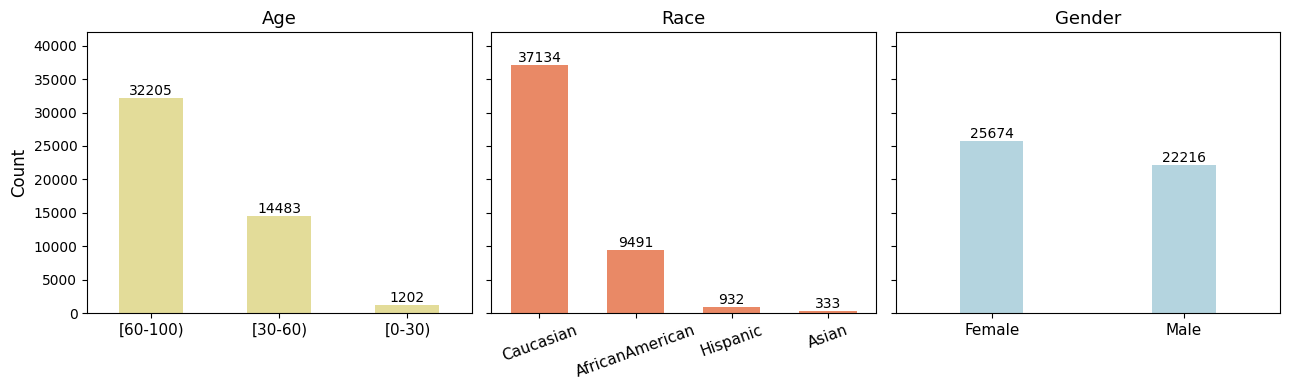

In [24]:
age_counts = protected_groups_.groupby('age').size()
race_counts = protected_groups_.groupby('race').size()
gender_counts = protected_groups_.groupby('gender').size()
age_counts = age_counts.sort_values(ascending=False)
race_counts = race_counts.sort_values(ascending=False)
gender_counts = gender_counts.sort_values(ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)  

sns.barplot(x=age_counts.index, y=age_counts.values, ax=axes[0], color='khaki', width=0.5)
axes[0].set_title('Age', fontsize=13)
axes[0].set_xlabel('')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].bar_label(axes[0].containers[0]) 
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0, ha='center', fontsize=11)
axes[0].set_ylim(0,42000)

sns.barplot(x=race_counts.index, y=race_counts.values, ax=axes[1], color='coral', width=0.6)
axes[1].set_title('Race', fontsize=13)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].bar_label(axes[1].containers[0])  
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=20, ha='center', fontsize=11)
axes[1].set_ylim(0,42000)

sns.barplot(x=gender_counts.index, y=gender_counts.values, ax=axes[2], color='lightblue', width=0.33)
axes[2].set_title('Gender', fontsize=13)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].bar_label(axes[2].containers[0]) 
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0, ha='center', fontsize=11)
axes[2].set_ylim(0,42000)

plt.tight_layout()
plt.savefig(FIGURES_PATH+"count_downsampled.svg") 
plt.show()

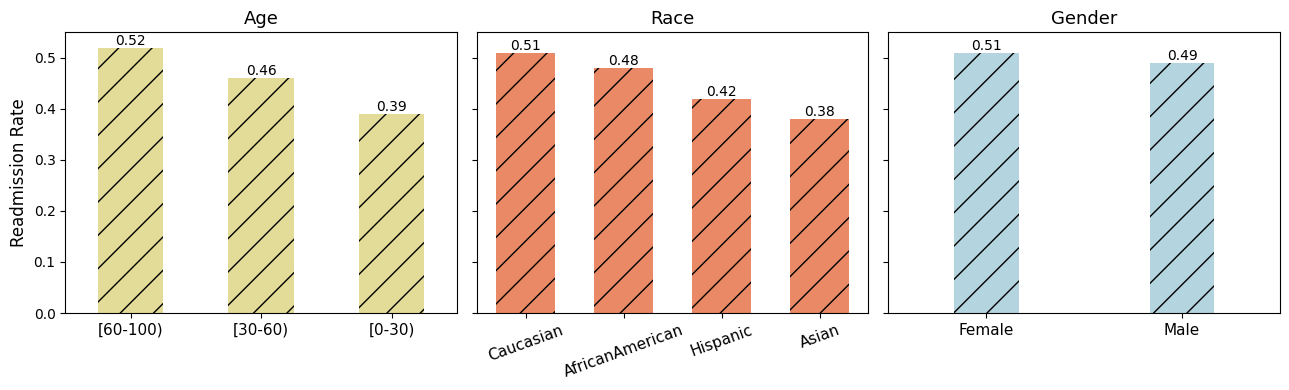

In [25]:
age_counts = protected_groups_.groupby('age')['readmitted_flag'].mean()
race_counts = protected_groups_.groupby('race')['readmitted_flag'].mean()
gender_counts = protected_groups_.groupby('gender')['readmitted_flag'].mean()
age_counts = age_counts.sort_values(ascending=False)
race_counts = race_counts.sort_values(ascending=False)
gender_counts = gender_counts.sort_values(ascending=False)
age_counts = age_counts.round(2)
race_counts = race_counts.round(2)
gender_counts = gender_counts.round(2)

fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)  

sns.barplot(x=age_counts.index, y=age_counts.values, ax=axes[0], color='khaki', width=0.5, hatch='/')
axes[0].set_title('Age', fontsize=13)
axes[0].set_xlabel('')
axes[0].set_ylabel('Readmission Rate', fontsize=12)
axes[0].bar_label(axes[0].containers[0]) 
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0, ha='center', fontsize=11)
axes[0].set_ylim(0,0.55)

sns.barplot(x=race_counts.index, y=race_counts.values, ax=axes[1], color='coral', width=0.6, hatch='/')
axes[1].set_title('Race', fontsize=13)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].bar_label(axes[1].containers[0])  
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=20, ha='center', fontsize=11)
axes[1].set_ylim(0,0.55)

sns.barplot(x=gender_counts.index, y=gender_counts.values, ax=axes[2], color='lightblue', width=0.33, hatch='/')
axes[2].set_title('Gender', fontsize=13)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].bar_label(axes[2].containers[0]) 
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0, ha='center', fontsize=11)
axes[2].set_ylim(0,0.55)

plt.tight_layout()
plt.savefig(FIGURES_PATH+"demographic_parity_downsampled.svg") 

## ROC AUC Figures

In [26]:
# with inspiration for ROC manual plotting from https://towardsdatascience.com/interpreting-roc-curve-and-roc-auc-for-classification-evaluation-28ec3983f077
def calculate_tpr_fpr(y_real, y_pred):
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

def get_n_roc_coordinates(y_real, y_proba, n = 99):
    tpr_list = [0]
    fpr_list = [0]
    for i in range(n):
        threshold = i/n
        y_pred = y_proba[:, 1] > threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

def RMSE(array):

    means = np.mean(array, axis=1)
    SE = np.apply_along_axis(lambda x: (x - means)**2, 0, array)
    MSE = np.mean(SE, axis=1)
    RMSE = np.sqrt(MSE)

    return RMSE

In [27]:
def roc_curve_protected(X_train, y_train, X_test, y_test, group_train, group_test, PROTECTED_FEATURES):
    
    # set seaborn color palette
    sns_colors = sns.color_palette("muted")
    
    # debias data
    X_train_decorrelated = correlation_remover(X_train, group_train, lambda_=0)
    X_test_decorrelated = correlation_remover(X_test, group_test, lambda_=0)

    # get probas for baseline model
    base_preds, base_probas, _ = fit_logistic_regression(X_train, y_train, X_test)
    
    # get probas for debiased data 
    debiased_preds, debiased_probas, _ = fit_logistic_regression(X_train_decorrelated, y_train, X_test_decorrelated)
    
    # compile df for plotting
    plot_data = pd.from_dummies(group_test,sep='_')
    plot_data["baseline_proba_0"] = base_probas[:, 0]
    plot_data["baseline_proba_1"] = base_probas[:, 1]
    plot_data["debiased_proba_0"] = debiased_probas[:, 0]
    plot_data["debiased_proba_1"] = debiased_probas[:, 1]

    plot_data["true"] = y_test

    _bar, axes_bar = plt.subplots(1, len(PROTECTED_FEATURES),figsize=(8,4),sharey=True)
    _, axes = plt.subplots(2, len(PROTECTED_FEATURES),figsize=(12, 8), sharex='col', sharey='row')
    axes[0,0].set_xlim(-0.05, 1.05)
    axes[0,0].set_ylim(-0.05, 1.05)
    axes[0,0].set_ylabel("True Positive Rate", fontsize=15)
    axes[1,0].set_ylabel("True Positive Rate", fontsize=15)
    # _.suptitle("ROC curves for baseline and debiased models",fontsize=15)
    
    c = 0
    feature_names = ["Age", "Race", "Gender"]
    tpr_rmse = {}
    fpr_rmse = {}
    # Iterate through each protected feature
    for i, feature in enumerate(PROTECTED_FEATURES):
        tpr_rmse[feature] = {}
        fpr_rmse[feature] = {}
        sns.lineplot(x = [0, 1], y = [0, 1], color = 'black', ax=axes[0,i], linestyle='--')
        sns.lineplot(x = [0, 1], y = [0, 1], color = 'black', ax=axes[1,i], linestyle='--')
        axes[1,i].set_xlabel("False Positive Rate", fontsize=15)
        axes[0,i].set_title(f"{feature_names[i]}", fontsize=15)
        # Iterate through each category of the protected feature
        for category in np.unique(plot_data[feature]):

            # Calculate tpr and fpr for baseline model and debiased model
            cat_true, cat_proba_preds_baseline_0,  cat_proba_preds_baseline_1 = plot_data[plot_data[feature]==category][["true", "baseline_proba_0", "baseline_proba_1"]].to_numpy().T
            cat_true, cat_proba_preds_debiased_0, cat_proba_preds_debiased_1 = plot_data[plot_data[feature]==category][["true", "debiased_proba_0", "debiased_proba_1"]].to_numpy().T

            # calculate roc curve for with baseline and debiased predictions
            tpr_baseline, fpr_baseline = get_n_roc_coordinates(cat_true, np.column_stack((cat_proba_preds_baseline_0, cat_proba_preds_baseline_1)))
            tpr_debiased, fpr_debiased = get_n_roc_coordinates(cat_true, np.column_stack((cat_proba_preds_debiased_0, cat_proba_preds_debiased_1)))
            
            # plot roc curve for baseline and debiased model
            sns.lineplot(x = fpr_baseline, y = tpr_baseline, ax=axes[0,i],label=category,color=sns_colors[c])
            sns.lineplot(x = fpr_debiased, y = tpr_debiased, ax=axes[1,i],label=category,color=sns_colors[c])
            c += 1

            try: 
                # TPR
                tpr_rmse[feature]["baseline_tpr"] = np.column_stack((tpr_rmse[feature]["baseline_tpr"], np.array(tpr_baseline)))
                tpr_rmse[feature]["debiased_tpr"] = np.column_stack((tpr_rmse[feature]["debiased_tpr"], np.array(tpr_debiased)))
                
                # FPR
                fpr_rmse[feature]["baseline_fpr"] = np.column_stack((fpr_rmse[feature]["baseline_fpr"], np.array(fpr_baseline)))
                fpr_rmse[feature]["debiased_fpr"] = np.column_stack((fpr_rmse[feature]["debiased_fpr"], np.array(fpr_debiased)))
            
            except:
                # TPR
                tpr_rmse[feature]["baseline_tpr"] = np.array(tpr_baseline)
                tpr_rmse[feature]["debiased_tpr"] = np.array(tpr_debiased)
                
                # FPR
                fpr_rmse[feature]["baseline_fpr"] = np.array(fpr_baseline)
                fpr_rmse[feature]["debiased_fpr"] = np.array(fpr_debiased)


        # Calculate RMSE for TPR for each feature before and after debiasing
        # Before Debiasing
        tpr_rmse[feature]["baseline_rmse"] = RMSE(tpr_rmse[feature]["baseline_tpr"])
        tpr_rmse[feature]["baseline_mean_rmse"] = np.mean(tpr_rmse[feature]["baseline_rmse"])
        tpr_rmse[feature]["baseline_std_rmse"] = np.std(tpr_rmse[feature]["baseline_rmse"])
        # After Debiasing
        tpr_rmse[feature]["debiased_rmse"] = RMSE(tpr_rmse[feature]["debiased_tpr"])
        tpr_rmse[feature]["debiased_mean_rmse"] = np.mean(tpr_rmse[feature]["debiased_rmse"])
        tpr_rmse[feature]["debiased_std_rmse"] = np.std(tpr_rmse[feature]["debiased_rmse"])

        # Calculate RMSE for FPR for each feature
        # Before Debiasing
        fpr_rmse[feature]["baseline_rmse"] = RMSE(fpr_rmse[feature]["baseline_fpr"])
        fpr_rmse[feature]["baseline_mean_rmse"] = np.mean(fpr_rmse[feature]["baseline_rmse"])
        fpr_rmse[feature]["baseline_std_rmse"] = np.std(fpr_rmse[feature]["baseline_rmse"])
        
        # After Debiasing
        fpr_rmse[feature]["debiased_rmse"] = RMSE(fpr_rmse[feature]["debiased_fpr"])
        fpr_rmse[feature]["debiased_mean_rmse"] = np.mean(fpr_rmse[feature]["debiased_rmse"])
        fpr_rmse[feature]["debiased_std_rmse"] = np.std(fpr_rmse[feature]["debiased_rmse"])


        # Plot bar plot for RMSE for TPR and FPR to show the difference before and after debiasing
        bars = axes_bar[i].bar(x = [0,1,2,3], tick_label=["Baseline (TPR)", "Debiased (TPR)", "Baseline (FPR)", "Debiased (FPR)"],
            height=[tpr_rmse[feature]["baseline_mean_rmse"], tpr_rmse[feature]["debiased_mean_rmse"], fpr_rmse[feature]["baseline_mean_rmse"], fpr_rmse[feature]["debiased_mean_rmse"]],
            align="center",yerr=[tpr_rmse[feature]["baseline_std_rmse"], tpr_rmse[feature]["debiased_std_rmse"], fpr_rmse[feature]["baseline_std_rmse"], fpr_rmse[feature]["debiased_std_rmse"]],
            capsize=5, color=['tab:blue', 'tab:blue','tab:red', 'tab:red'])
        
        axes_bar[i].set_title(f"{feature_names[i]}")
        axes_bar[i].set_xticklabels(labels=[" ", " ", " ", " "],rotation=45, ha="right")
        for bar, label in zip(bars, ["Baseline (TPR)", "Debiased (TPR)", "Baseline (FPR)", "Debiased (FPR)"]):
            if 'Debiased' in label:
                bar.set_hatch('//')
    # Custom legend
    baseline_patch = mpatches.Patch(color='tab:blue', label='Baseline (TPR)')
    debiased_patch = mpatches.Patch(facecolor='tab:blue', hatch='//', label='Debiased (TPR)')
    fpr_patch = mpatches.Patch(color='tab:red', label='Baseline (FPR)')
    tpr_patch = mpatches.Patch(facecolor='tab:red', hatch='//', label='Debiased (FPR)')

    # Add the legend to the plot
    axes_bar[2].legend(handles=[baseline_patch, debiased_patch, fpr_patch, tpr_patch], loc='upper right')
     # title = RMSE for True Positive Rate before and after debiasing the data
    axes_bar[0].set_ylabel("Aggregated RMSE evaluated at all thresholds")
    return (_, axes), (_bar, axes_bar)

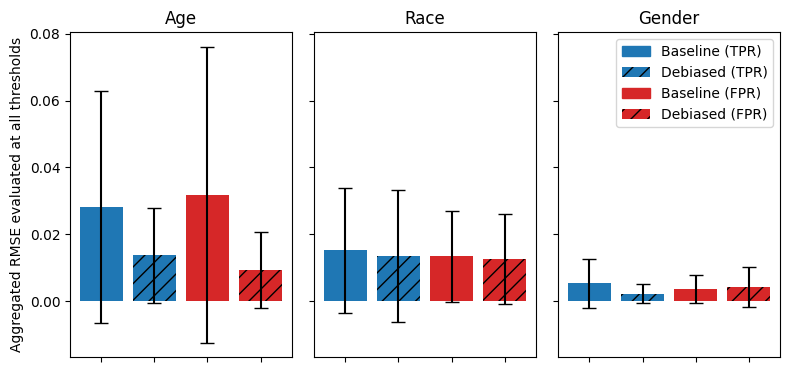

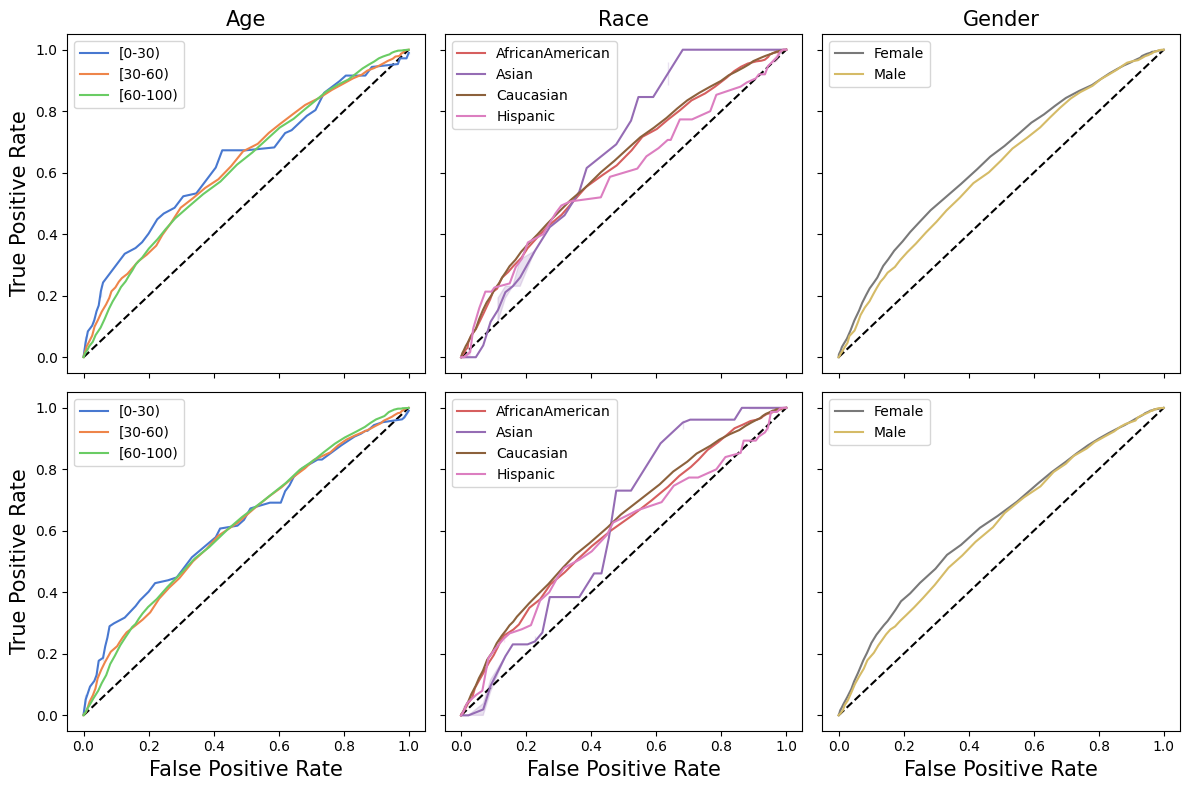

In [28]:
ax, axes_bar = roc_curve_protected(X_train, y_train, X_test, y_test, group_train, group_test, PROTECTED_FEATURES)
axes_bar[0].tight_layout()
axes_bar[0].subplots_adjust(wspace=0.1, hspace=0)
ax[0].tight_layout()
axes_bar[0].savefig(FIGURES_PATH+"rmse.svg", format="svg")
ax[0].savefig(FIGURES_PATH+"roc_curve.svg", format="svg")

## Coefficient Figure

In [29]:
#Get coefficients for the baseline dataset
_, _, coefs = fit_logistic_regression(X_train, y_train, X_test)

#Calculate decorrelated train, and test faetures and get decorrelated coefficients
X_train_decorrelated = correlation_remover(X_train, group_train, 0)
X_test_decorrelated = correlation_remover(X_test, group_test, 0)    
_, _, coefs_decorrelated = fit_logistic_regression(X_train_decorrelated, y_train, X_test_decorrelated)

coeffs_diffs = -(abs(coefs)-abs(coefs_decorrelated))[0]

In [30]:
# Create a DataFrame for easy sorting
coefs_diff_df = pd.DataFrame({
    'Feature': X_train.columns,
    'coefs': coefs[0],
    'coefs_decorrelated': coefs_decorrelated[0],
    'Coefficient Difference': coeffs_diffs
})

# Sort the DataFrame by coefficient difference
coefs_diff_df = coefs_diff_df.sort_values(by='Coefficient Difference', ascending=False)

C:\Users\ah140\AppData\Local\Temp\ipykernel_23508\3946477348.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_colors = plt.cm.get_cmap(pal)


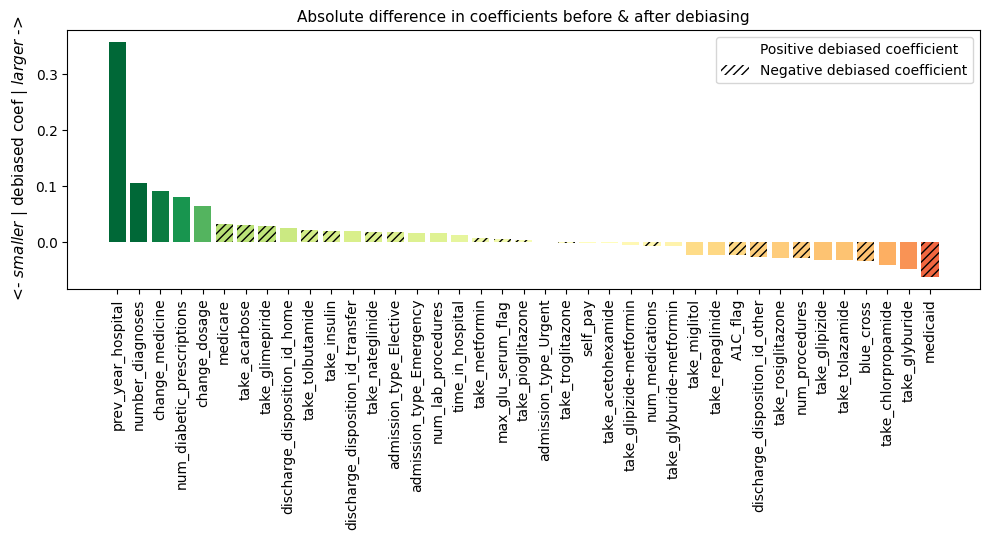

In [31]:
# Get the data for color normalization
data_color = coefs_diff_df['Coefficient Difference']

# Choose the colormap
pal = 'RdYlGn'
my_colors = plt.cm.get_cmap(pal)

# Normalize the data
norm = Normalize(-0.1, 0.1)
colors = my_colors(norm(data_color))

# Plotting the differences in coefficients
plt.figure(figsize=(10, 5.5))
bars = plt.bar(coefs_diff_df['Feature'], coefs_diff_df['Coefficient Difference'], color=colors)
plt.ylabel(' <- $\it{smaller}$ | debiased coef | $\it{larger}$ -> ', fontsize=11)
plt.title('Absolute difference in coefficients before & after debiasing', fontsize=11)
plt.xticks(rotation=90)

for bar, value in zip(bars, coefs_diff_df['coefs_decorrelated']):
    if value < 0:
        bar.set_hatch('////')

# Custom legend
baseline_patch = mpatches.Patch(color='white', label='Positive debiased coefficient')
debiased_patch = mpatches.Patch(facecolor='white', hatch='////', label='Negative debiased coefficient')

# Add the legend to the plot
plt.legend(handles=[baseline_patch, debiased_patch], loc='upper right')
plt.tight_layout()
plt.savefig(FIGURES_PATH+"coefficients_difference.svg") 

## Fairness-Accuracy Figures

In [32]:
def rmse_group(metrics):
    '''
    Calculates root-mean-squared-error for each lambda for a given metric and a given group.
    '''
    num_groups = len(metrics[0])
    means = [np.mean(x) for x in metrics]
    
    RMSEs = []
    for observation, mean in zip(metrics, means):
        mse_observation = []
        for value in observation:
            mse_value = (value-mean)**2
            mse_observation.append(mse_value)
            
        mse_observation = math.sqrt(sum(mse_observation)/num_groups)    
        RMSEs.append(mse_observation)
                
    return RMSEs    

In [33]:
#Calculate mean across groups
RMSEs_ = []
for metric in [gender_tprs, gender_fprs, race_tprs, race_fprs, age_tprs, age_fprs]:
    rmse = rmse_group(metric)
    RMSEs_.append(rmse)
RMSEs_ = np.array(RMSEs_) #shape (6, 31): 6 metrics and 31 lambdas

In [34]:
#calculate overall mean across all metrics per lambda 
overall_fairness = []
for j in range(0,RMSEs_.shape[1]):
    mean_rmse_pr_lambda = []
    
    for i in range(0,RMSEs_.shape[0]):
        mean_rmse_pr_lambda.append(RMSEs_[i][j])
    
    mean_rmse_pr_lambda = sum(mean_rmse_pr_lambda)/RMSEs_.shape[0]
    overall_fairness.append(mean_rmse_pr_lambda)

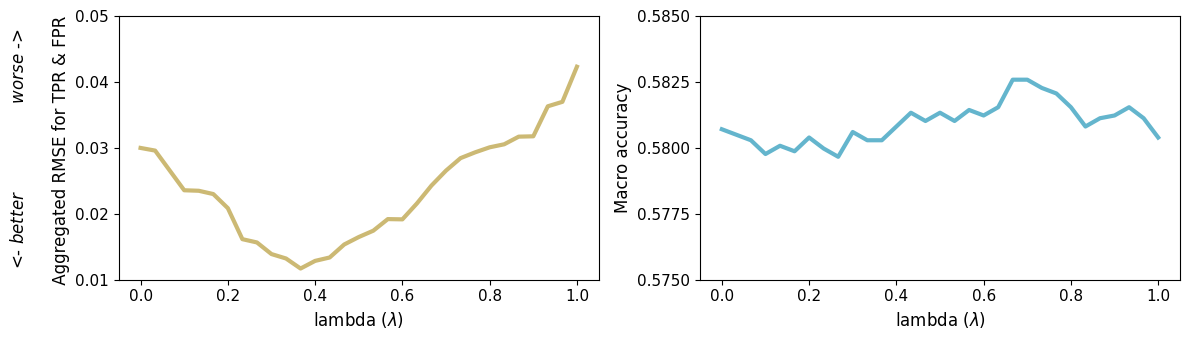

In [35]:
palette = sns.color_palette('deep')[8:10]
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5), sharey=False)
axes = axes.flatten()

for ax_, data, color, i in zip(axes, [overall_fairness, overall_accuracies], palette, [0,1]):
    ax_.plot(LAMBDAS, data, color=color, linewidth=3) 
    
    if i == 0:
        ax_.set_ylabel('<- $\it{better}$                 $\it{worse}$ -> \n \n Aggregated RMSE for TPR & FPR  ', fontsize=12)
        ax_.set_ylim(0.01,0.05)
        ax_.set_yticks([0.01, 0.02, 0.03, 0.04, 0.05])
    if i == 1:
        ax_.set_ylabel('Macro accuracy', fontsize=12)
        ax_.set_ylim(0.575,0.5850)
        ax_.set_yticks([0.5750, 0.5775, 0.58, 0.5825, 0.5850])
    
    ax_.tick_params(axis='x', labelsize=11)
    ax_.tick_params(axis='y', labelsize=11)
    ax_.set_xlabel('lambda ($\lambda$)', fontsize=12)
    
     
plt.tight_layout()
plt.savefig(FIGURES_PATH+"fairness_vs_accuracy.svg") 

## Line Figure


In [36]:
def create_data_plot_df(num_lambda):
    x_axis = np.linspace(0,1,num_lambda)
    data_plot_gender = pd.DataFrame(columns=('lambda ($\lambda$)', 'TPR', 'FPR', 'Gender'))
    data_plot_race = pd.DataFrame(columns=('lambda ($\lambda$)', 'TPR', 'FPR', 'Race'))
    data_plot_age= pd.DataFrame(columns=('lambda ($\lambda$)', 'TPR', 'FPR', 'Age'))
    
    
    for col in np.arange(len(gender_name)):
        data_plot_gender_ = pd.DataFrame({'lambda ($\lambda$)': x_axis,
                                        'TPR': [j[col] for j in gender_tprs],
                                        'FPR': [j[col] for j in gender_fprs],
                                        'Gender': gender_name[col].split('_')[1]
                                        })
        data_plot_gender = pd.concat([data_plot_gender, data_plot_gender_])
        
    for col in np.arange(len(race_name)):
        data_plot_race_ = pd.DataFrame({'lambda ($\lambda$)': x_axis,
                                        'TPR': [j[col] for j in race_tprs],
                                        'FPR': [j[col] for j in race_fprs],
                                        'Race': race_name[col].split('_')[1]
                                        })
        data_plot_race = pd.concat([data_plot_race, data_plot_race_])    
        
    for col in np.arange(len(age_name)):
        data_plot_age_ = pd.DataFrame({'lambda ($\lambda$)': x_axis,
                                        'TPR': [j[col] for j in age_tprs],
                                        'FPR': [j[col] for j in age_fprs],
                                        'Age': age_name[col].split('_')[1]
                                        })
        data_plot_age = pd.concat([data_plot_age, data_plot_age_]) 

    return data_plot_gender, data_plot_race, data_plot_age

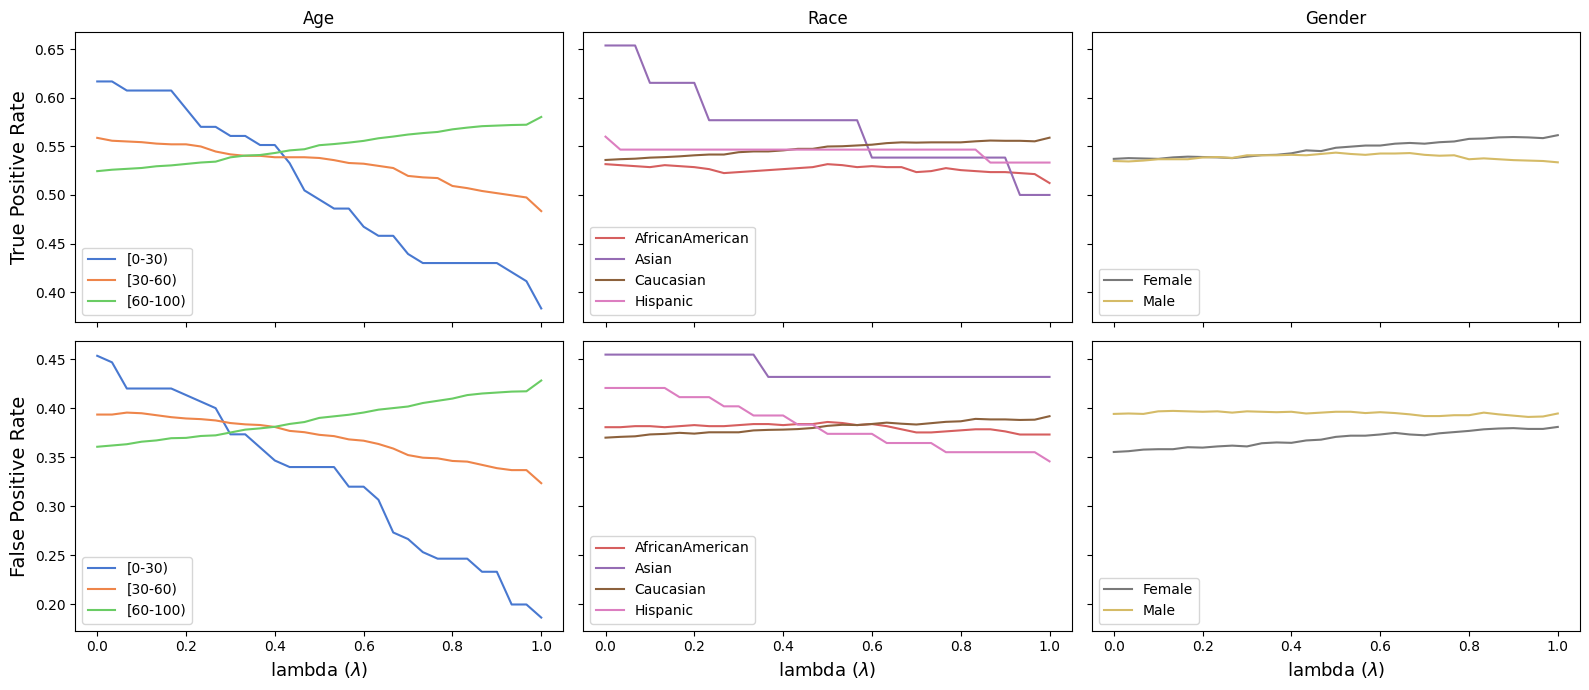

In [41]:
df_g, df_r, df_a = create_data_plot_df(num_lambda)
fig, axes = plt.subplots(2, 3, figsize=(16, 7), sharex='col', sharey='row')
axes = axes.T.flatten()

palette = sns.color_palette("muted")[0:3]
sns.set_palette(palette)
for ax_, data, metric in zip(axes[0:2], [df_a, df_a], ['TPR', 'FPR']):
    sns.lineplot(ax=ax_, data=data,
        x=data["lambda ($\lambda$)"], y=metric, hue=data.columns[3],
        markers=True, dashes=False
    )
    if metric == 'TPR':
        ax_.set_ylabel('True Positive Rate', fontsize=14)
    if metric == 'FPR':
        ax_.set_ylabel('False Positive Rate', fontsize=14)
    ax_.set_xlabel('lambda ($\lambda$)', fontsize=13)
    handles, labels = ax_.get_legend_handles_labels()
    ax_.legend(handles=handles[0:], labels=labels[0:],loc='lower left')
    if metric == 'TPR':
        ax_.set_title('Age')
    
palette = sns.color_palette("muted")[3:7]
sns.set_palette(palette)

for ax_, data, metric in zip(axes[2:4], [df_r, df_r], ['TPR', 'FPR']):
    sns.lineplot(ax=ax_, data=data,
        x=data["lambda ($\lambda$)"], y=metric, hue=data.columns[3],
        markers=True, dashes=False
    )
    ax_.set_ylabel('')
    ax_.set_xlabel('lambda ($\lambda$)', fontsize=13)
    handles, labels = ax_.get_legend_handles_labels()
    ax_.legend(handles=handles[0:], labels=labels[0:],loc='lower left')
    if metric == 'TPR':
        ax_.set_title('Race')

palette = sns.color_palette("muted")[7:9]
sns.set_palette(palette)
for ax_, data, metric in zip(axes[4:6], [df_g, df_g], ['TPR', 'FPR']):
    sns.lineplot(ax=ax_, data=data,
        x=data["lambda ($\lambda$)"], y=metric, hue=data.columns[3],
        markers=True, dashes=False
    )
    ax_.set_ylabel('') 
    ax_.set_xlabel('lambda ($\lambda$)', fontsize=13)
    handles, labels = ax_.get_legend_handles_labels()
    ax_.legend(handles=handles[0:], labels=labels[0:],loc='lower left')
    if metric == 'TPR':
        ax_.set_title('Gender')

  
plt.tight_layout()
plt.savefig(FIGURES_PATH+"lineplot.svg")

## Correlation Figure

In [38]:
df_one_hot_corr_plot_features = pd.concat([X_train, X_test])
df_one_hot_corr_plot_protectedfeatures = pd.concat([group_train, group_test])
df_one_hot_corr_plot = pd.concat([df_one_hot_corr_plot_features, df_one_hot_corr_plot_protectedfeatures], axis=1)

corr_matrix = df_one_hot_corr_plot.corr(method='pearson')
corr_matrix = corr_matrix[PROTECTED_FEATURES_ONE_HOT].reset_index() #only keep protected features as cols
corr_matrix = corr_matrix.drop([i for i in range(len(FEATURES_ONE_HOT)-1,corr_matrix.shape[0])]) #remove protected features from rows
corr_matrix = corr_matrix.set_index('index')

In [39]:
df_one_hot_corr_plot_features_decorrelated = correlation_remover(df_one_hot_corr_plot_features, 
                                                                 df_one_hot_corr_plot_protectedfeatures ,0)
df_one_hot_corr_plot_features_decorrelated.set_index(df_one_hot_corr_plot.index, inplace=True)
df_one_hot_corr_plot_decorrelated = pd.concat([df_one_hot_corr_plot_features_decorrelated, df_one_hot_corr_plot_protectedfeatures], axis=1)

corr_matrix_decorrelated = df_one_hot_corr_plot_decorrelated.corr(method='spearman')
corr_matrix_decorrelated = corr_matrix_decorrelated[PROTECTED_FEATURES_ONE_HOT].reset_index() #only keep protected features as cols
corr_matrix_decorrelated = corr_matrix_decorrelated.drop([i for i in range(len(FEATURES_ONE_HOT)-1,corr_matrix_decorrelated.shape[0])]) #remove protected features from rows
corr_matrix_decorrelated = corr_matrix_decorrelated.set_index('index')

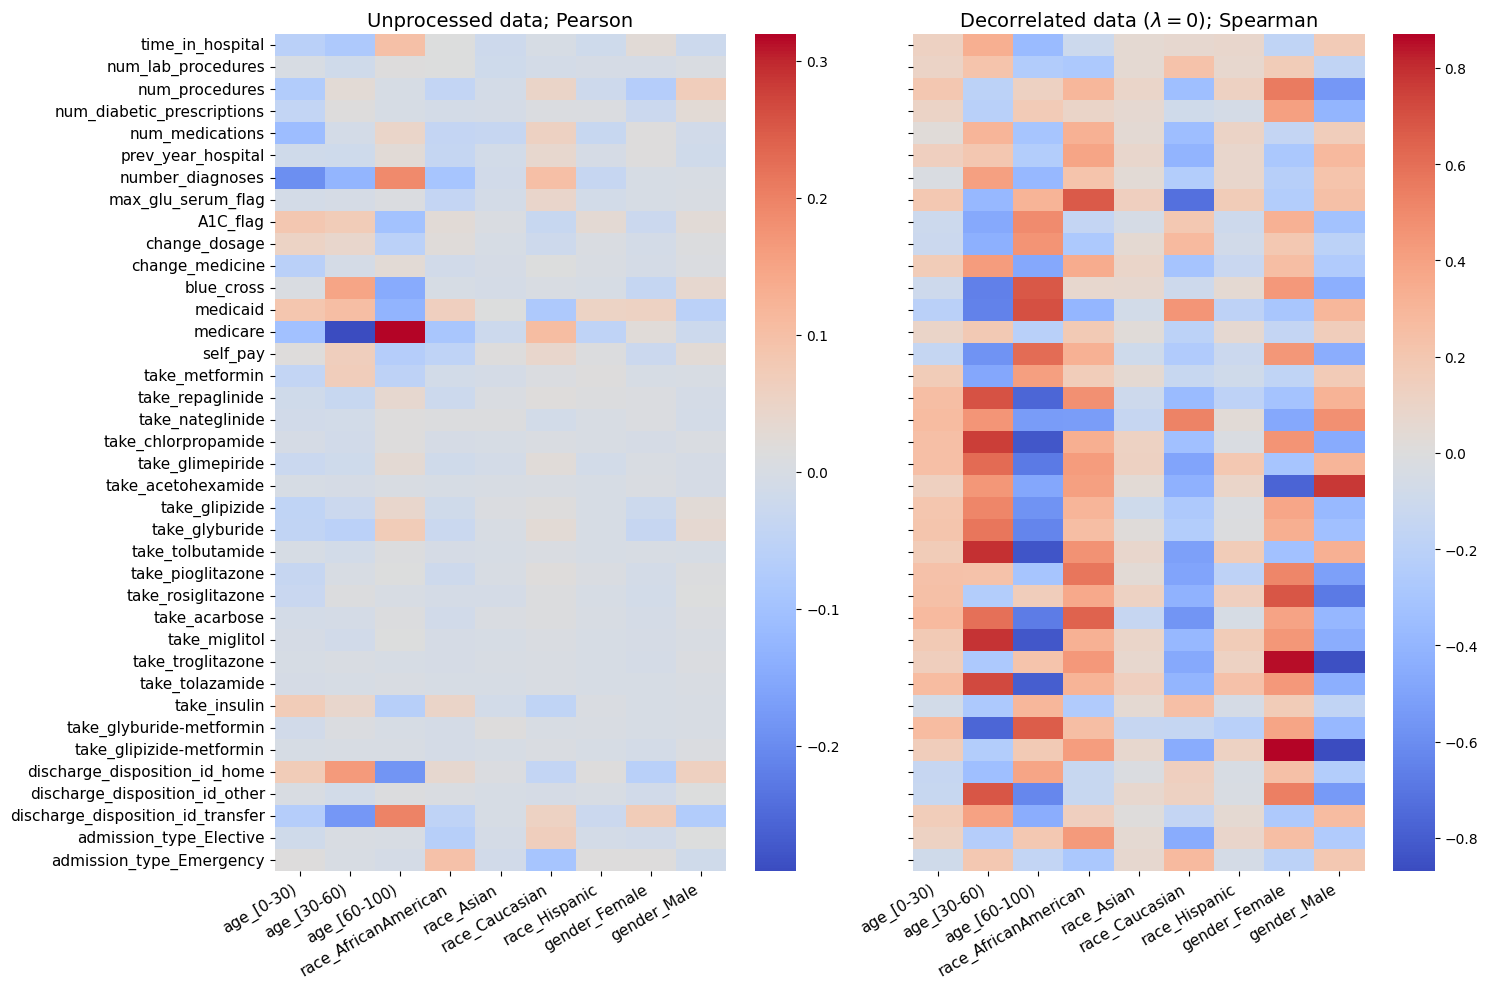

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes = axes.T.flatten()

for ax_, data_corr, i in zip(axes, [corr_matrix, corr_matrix_decorrelated], [0, 1]):
    sns.heatmap(ax=ax_, data=data_corr, cmap='coolwarm')
    
    ax_.set_ylabel('')
    if i == 0:
        ax_.set_title('Unprocessed data; Pearson', fontsize=14)
    if i == 1:
        ax_.set_yticklabels([])
        ax_.set_title('Decorrelated data ($\lambda=0$); Spearman', fontsize=14)
    
    # Rotate x-axis tick labels and increase font size
    ax_.tick_params(axis='x', labelsize=11)
    ax_.tick_params(axis='y', labelsize=11)
    ax_.set_xlabel(ax_.get_xlabel(), fontsize=11, ha='left')
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30, ha='right')
    ax_.set_ylabel(ax_.get_ylabel(), fontsize=11)
                   
plt.tight_layout()
plt.savefig(FIGURES_PATH+"corrplots.svg")